# [IAPR][iapr]: Lab 3 ‒  Classification



## Important notes

The lab assignments are designed to teach practical implementation of the topics presented during class well as
preparation for the final project, which is a practical project which ties together the topics of the course.

As such, in the lab assignments/final project, unless otherwise specified, you may, if you choose, use external
functions from image processing/ML libraries like opencv and sklearn as long as there is sufficient explanation
in the lab report. For example, you do not need to implement your own edge detector, etc.

**! Before handling back the notebook <font color='red'> rerun </font>the notebook from scratch !**
`Kernel` > `Restart & Run All`

We will not rerun the notebook for you.


[iapr]: https://github.com/LTS5/iapr

## Extract relevant data
We first need to extract the `lab-03-data.tar.gz` archive.
To this end, we use the [tarfile] module from the Python standard library.

[tarfile]: https://docs.python.org/3.6/library/tarfile.html

In [1]:
import tarfile
import os

data_base_path = os.path.join(os.pardir, 'data')
data_folder = 'lab-03-data'
tar_path = os.path.join(data_base_path, data_folder + '.tar.gz')
with tarfile.open(tar_path, mode='r:gz') as tar:
    tar.extractall(path=data_base_path)

---
## Part 1
In this part, we will study classification based on the data available in the Matlab file `classification.mat` that you will under `lab-03-data/part1`.
There are 3 data sets in this file, each one being a training set for a given class.
They are contained in variables `a`, `b` and `c`.

**Note**: we can load Matlab files using the [scipy.io] module.

[scipy.io]: https://docs.scipy.org/doc/scipy/reference/io.html

In [2]:
import scipy.io

data_part1_path = os.path.join(data_base_path, data_folder, 'part1', 'classification.mat')
matfile = scipy.io.loadmat(data_part1_path)
a = matfile['a']
b = matfile['b']
c = matfile['c']

print(a.shape, b.shape, c.shape)

(200, 2) (200, 2) (200, 2)


In [3]:
import matplotlib.pyplot as plt
import numpy as np

Text(0, 0.5, 'y')

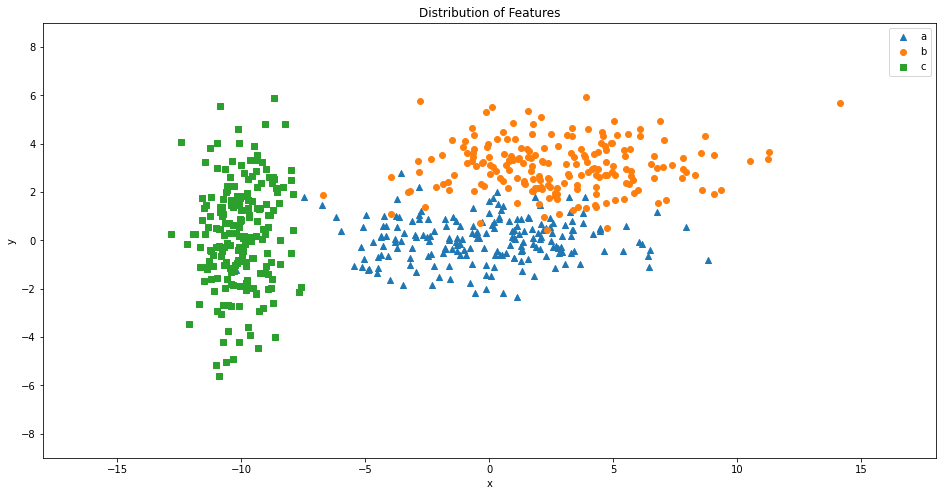

In [4]:
# Visualization of the Data
plt.figure(figsize=(16, 8))

plt.xlim([-18, 18])
plt.ylim([-9, 9])

plt.scatter(a[:,0], a[:,1], marker='^')
plt.scatter(b[:,0], b[:,1], marker='o')
plt.scatter(c[:,0], c[:,1], marker='s')

plt.title('Distribution of Features')
plt.legend(['a', 'b', 'c'])
plt.xlabel('x')
plt.ylabel('y')

The classes are assumed to be equiprobable. Mean and covariances of each class are calculated as follows:

In [5]:
# Calculate prior pdf of classes, mean and covariance matrices of the data

p_a = 1/3
p_b = 1/3
p_c = 1/3

mean_a = np.mean(a, axis=0)
mean_b = np.mean(b, axis=0)
mean_c = np.mean(c, axis=0)

print(mean_a)
print(mean_b)
print(mean_c, end='\n\n')

cov_a = np.cov(a.T)
cov_b = np.cov(b.T)
cov_c = np.cov(c.T)

print(cov_a)
print(cov_b)
print(cov_c)

[-0.21000115  0.03048009]
[2.8018991 3.0535643]
[-10.05748461   0.22582978]

[[10.02769733  0.13162336]
 [ 0.13162336  0.83932673]]
[[10.17034812  0.18023771]
 [ 0.18023771  1.0840038 ]]
[[0.97013029 0.23458112]
 [0.23458112 4.69756273]]


### 1.1 Bayes method (5 pts)
Using the Bayes method, give the expression of the separation curves between those three classes.
Do reasonable hypotheses about the distributions of those classes and estimate the corresponding parameters based on the given training sets.
Draw those curves on a plot, together with the training data. Note that you do not need to solve the analytical expression. You can simply evaluate the function for each point on the plane to end up with a segmentation map.
For simplicity reasons, round the estimated parameters to the closest integer value.

The distribution of classes are assumed to be Gaussian. 

We have 3 classes in this lab. Therefore, we need 3 separation curves, each curve is separating 2 different classes. 
The expression of the separation curve between classes i and j is given as follows:

$$g_i(x) - g_j(x) = 0 $$
$$-\frac{1}{2}(x-\mu_i)^T \Sigma_i^{-1} (x-\mu_i) + ln(P(w_i)) + c_i + \frac{1}{2}(x-\mu_j)^T \Sigma_j^{-1} (x-\mu_j) - ln(P(w_j)) - c_j = 0$$

Since the priori of each class is the same, the curve expression becomes:

$$g_i(x) - g_j(x) = -\frac{1}{2}(x-\mu_i)^T \Sigma_i^{-1} (x-\mu_i) + c_i + \frac{1}{2}(x-\mu_j)^T \Sigma_j^{-1} (x-\mu_j) - c_j = 0$$

The following function calculates the discriminant function assuming the distribution of the classes are Gaussian.

In [6]:
def eval_sample_feature(x, mean, cov, pdf):
    
    inv_cov = np.linalg.inv(cov)
    det_cov = np.linalg.det(cov)
    
    term1 = -1/2 * (np.dot((x - mean).T, inv_cov).dot(x - mean))
    term2 = np.log(pdf)
    term3 = np.log(1 / ((2*np.pi) * det_cov**1/2))
    
    return term1 + term2 + term3

In [7]:
print(eval_sample_feature(a[0,:], mean_a, cov_a, p_a))

-5.5583231738518855


The following function is used to determine the decision curves between classes. The probabilities that are calculated with *eval_sample_feature* are compared and if the difference between the probabilities are below 0.0001, the point is defined as a part of the decision curve.

In [8]:
def find_numerical_intersection(means, covs, pdfs, eval_func):
    x_range = np.arange(-18, 18, 0.005)
    y_range = np.arange(-9, 9, 0.005)
    
    inters_points = []
    
    for x in x_range:
        for y in y_range:
            data_point = np.array([x, y])
            eval_1 = eval_func(data_point, means[0], covs[0], pdfs[0])
            eval_2 = eval_func(data_point, means[1], covs[1], pdfs[1])
            if abs(eval_1 - eval_2) < 0.0001:
                print(x, y)
                inters_points.append((x, y))
                
    return np.array(inters_points)

In [9]:
curve_ab = find_numerical_intersection([mean_a, mean_b], [cov_a, cov_b], [p_a, p_b], eval_sample_feature)
curve_ac = find_numerical_intersection([mean_a, mean_c], [cov_a, cov_c], [p_a, p_c], eval_sample_feature)
curve_bc = find_numerical_intersection([mean_b, mean_c], [cov_b, cov_c], [p_b, p_c], eval_sample_feature)

-17.920000000000016 2.905000000001861
-17.765000000000047 2.8950000000018594
-17.610000000000078 2.885000000001858
-17.225000000000154 2.860000000001854
-16.53500000000029 2.815000000001847
-16.230000000000352 2.795000000001844
-15.850000000000428 2.77000000000184
-15.320000000000533 2.7350000000018344
-15.245000000000548 2.7300000000018336
-15.170000000000563 2.725000000001833
-14.345000000000727 2.6700000000018242
-14.270000000000742 2.6650000000018235
-13.67500000000086 2.625000000001817
-13.305000000000934 2.6000000000018133
-13.010000000000993 2.58000000000181
-12.350000000001124 2.535000000001803
-11.985000000001197 2.5100000000017992
-11.11500000000137 2.45000000000179
-10.755000000001441 2.425000000001786
-10.325000000001527 2.3950000000017813
-10.11000000000157 2.380000000001779
-9.825000000001626 2.360000000001776
-9.470000000001697 2.335000000001772
-8.975000000001796 2.3000000000017664
-7.575000000002074 2.2000000000017508
-7.090000000002171 2.1650000000017453
-6.7450000000

In [10]:
print(curve_ab.shape)
print(curve_ac.shape)
print(curve_bc.shape)

(100, 2)
(48, 2)
(44, 2)


Below, the training data as well as the decision curves are illustrated.

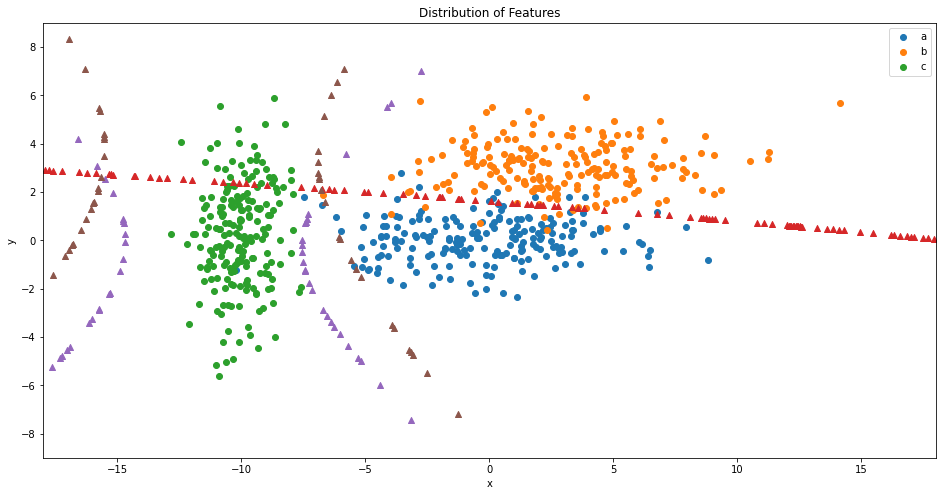

In [11]:
# Visualization of the Data
plt.figure(figsize=(16, 8))

plt.xlim([-18, 18])
plt.ylim([-9, 9])

plt.scatter(a[:,0], a[:,1])
plt.scatter(b[:,0], b[:,1])
plt.scatter(c[:,0], c[:,1])

plt.title('Distribution of Features')
plt.legend(['a', 'b', 'c'])
plt.xlabel('x')
plt.ylabel('y')

plt.scatter(curve_ab[:,0], curve_ab[:,1], marker='^')
plt.scatter(curve_ac[:,0], curve_ac[:,1], marker='^')
plt.scatter(curve_bc[:,0], curve_bc[:,1], marker='^')


### 1.2 Mahalanobis distance (5 pts)
For classes `a` and `b`, give the expression of the Mahalanobis distance used to classify a point in class `a` or `b`, and verify the obtained classification, in comparison with the "complete" Bayes classification, for a few points of the plane.

The expression for the Mahalanobis distance is:
$$d_m = ((x-\mu_i) \Sigma^{-1} (x-\mu_i))^{1/2}$$

In [12]:
def eval_mahala(data_point, mean, cov):
    inv_cov = np.linalg.inv(cov)
    result = np.dot((data_point - mean), inv_cov).dot((data_point - mean).T)
    return result**(1/2)

In [13]:
# Add your implementation and discussion

test_points = np.array([(0, 0), (0, 4), (5, 8), (3, -4)])


for i in range(test_points.shape[0]):
    
    dist_a = eval_mahala(test_points[i], mean_a, cov_a)
    dist_b = eval_mahala(test_points[i], mean_b, cov_b)
    
    print(f'Mahalanobis distance to class a of point{test_points[i]}:', dist_a)
    print(f'Mahalanobis distance to class b of point{test_points[i]}:', dist_b)
    
    if dist_a > dist_b:
        print(f'Point{test_points[i]}is closer to class b', end='\n\n')
    else:
        print(f'Point{test_points[i]}is closer to class a', end='\n\n')

Mahalanobis distance to class a of point[0 0]: 0.07560898942592024
Mahalanobis distance to class b of point[0 0]: 3.020053270184179
Point[0 0]is closer to class a

Mahalanobis distance to class a of point[0 4]: 4.334799795555961
Mahalanobis distance to class b of point[0 4]: 1.299971816556288
Point[0 4]is closer to class b

Mahalanobis distance to class a of point[5 8]: 8.788565813350603
Mahalanobis distance to class b of point[5 8]: 4.770512087231115
Point[5 8]is closer to class b

Mahalanobis distance to class a of point[ 3 -4]: 4.563948681331022
Mahalanobis distance to class b of point[ 3 -4]: 6.788413842450191
Point[ 3 -4]is closer to class a



As can be seen from the figure that shows the classes and the decision curves, the points [0,0] and [3,-4] belong to the class a, whereas the points [0,4] and [5,8] belong to the class b. After calculating the Mahalanobis distance, we reach to the same conclusion as the complete Bayes classification.

---

## Part 2
In this part, we aim to classify digits using the complete version of MNIST digits dataset.
The dataset consists of 60'000 training images and 10'000 test images of handwritten digits.
Each image has size 28x28, and has assigned a label from zero to nine, denoting the digits value.
Given this data, your task is to construct a Multilayer Perceptron (MLP) for supervised training and classification and evaluate it on the test images.

Download the MNIST dataset (all 4 files) from http://yann.lecun.com/exdb/mnist/ under `lab-03-data/part2`.
You can then use the script provided below to extract and load training and testing images in Python. 

**! Warning**: When the lab was created the official MNIST repo was down, if it is still the case please use https://github.com/mkolod/MNIST.

### 2.1 Dataset loading
Here we first declare the methods `extract_data` and `extract_labels` so that we can reuse them later in the code.
Then we extract both the data and corresponding labels, and plot randomly some images and corresponding labels of the training set.

In [14]:
import gzip
import numpy as np
import matplotlib.pyplot as plt
import os

def extract_data(filename, image_shape, image_number):
    with gzip.open(filename) as bytestream:
        bytestream.read(16)
        buf = bytestream.read(np.prod(image_shape) * image_number)
        data = np.frombuffer(buf, dtype=np.uint8).astype(np.float32)
        data = data.reshape(image_number, image_shape[0], image_shape[1])
    return data


def extract_labels(filename, image_number):
    with gzip.open(filename) as bytestream:
        bytestream.read(8)
        buf = bytestream.read(1 * image_number)
        labels = np.frombuffer(buf, dtype=np.uint8).astype(np.int64)
    return labels

In [15]:
image_shape = (28, 28)
train_set_size = 60000
test_set_size = 10000

data_part2_folder = os.path.join(data_base_path, data_folder, 'part2')

train_images_path = os.path.join(data_part2_folder, 'train-images-idx3-ubyte.gz')
train_labels_path = os.path.join(data_part2_folder, 'train-labels-idx1-ubyte.gz')
test_images_path = os.path.join(data_part2_folder, 't10k-images-idx3-ubyte.gz')
test_labels_path = os.path.join(data_part2_folder, 't10k-labels-idx1-ubyte.gz')

train_images = extract_data(train_images_path, image_shape, train_set_size)
test_images = extract_data(test_images_path, image_shape, test_set_size)
train_labels = extract_labels(train_labels_path, train_set_size)
test_labels = extract_labels(test_labels_path, test_set_size)

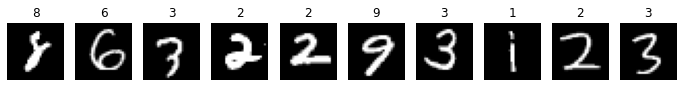

In [16]:
prng = np.random.RandomState(seed=123456789)  # seed to always re-draw the same distribution
plt_ind = prng.randint(low=0, high=train_set_size, size=10)

fig, axes = plt.subplots(1, 10, figsize=(12, 3))
for ax, im, lb in zip(axes, train_images[plt_ind], train_labels[plt_ind]):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(lb)

### 2.2 MLP (10 pts)

To create an MLP you are free to choose any library.
In case you don't have any preferences, we encourage you to use the [scikit-learn] package; it is a simple, efficient and free tool for data analysis and machine learning.
In this [link][sklearn-example], you can find a basic example to see how to create and train an MLP using [scikit-learn].
Your network should have the following properties:
* Input `x`: 784-dimensional (i.e. 784 visible units representing the flattened 28x28 pixel images).
* 100 hidden units `h`.
* 10 output units `y`, i.e. the labels, with a value close to one in the i-th class representing a high probability of the input representing the digit `i`.

If you need additional examples you can borrow some code from image classification tutorials.
However, we recommend that you construct a minimal version of the network on your own to gain better insights.

[scikit-learn]: http://scikit-learn.org/stable/index.html
[sklearn-example]: http://scikit-learn.org/stable/modules/neural_networks_supervised.html

We used tensorflow to implement an MLP. We referred to DeepLearning Specialization by DeepLearning AI as a code example.

In [17]:
import tensorflow as tf
from tensorflow.keras.utils import to_categorical

Training and test images are flattened and normalized before the classification.

In [18]:
def flatten(ims):
    flat_ims = ims.reshape((ims.shape[0], -1))
    flat_ims /= 255.0
    return flat_ims

In [19]:
train_ims = flatten(train_images)
test_ims = flatten(test_images)
print(train_ims.shape)
print(test_ims.shape)

(60000, 784)
(10000, 784)


Next, we should convert labels into one-hot encoding to train the softmax layer.

In [20]:
encoded_train_labels = to_categorical(train_labels, num_classes=10)
encoded_test_labels = to_categorical(test_labels, num_classes=10)

Flattened training and test images and labels are converted to tensors.

In [21]:
train_ims = tf.convert_to_tensor(train_ims)
test_ims = tf.convert_to_tensor(test_ims)
encoded_train_labels = tf.convert_to_tensor(encoded_train_labels)
encoded_test_labels = tf.convert_to_tensor(encoded_test_labels)

train_ims = tf.data.Dataset.from_tensor_slices(train_ims)
train_labels = tf.data.Dataset.from_tensor_slices(encoded_train_labels)
test_ims = tf.data.Dataset.from_tensor_slices(test_ims)
test_labs = tf.data.Dataset.from_tensor_slices(encoded_test_labels)

2022-04-29 01:26:56.085549: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


We used sigmoid activation function of the first layer.
To have a probability distribution as an output of the model, we used softmax function.
To train MLP with one hidden layer with 100 units, we needed two weight vectors and two bias vectors. 

$$W_1 X + b_1 = Z_1$$
$$sigmoid[Z_1] = a_1 $$ 

$$and $$

$$W_2 a_1 + b_2 = Z_2 $$
$$softmax[Z_2] = a_2 $$

In [22]:
# initialize parameters (weights and biases to be trained)
# Note that there are 100 hidden layer units
def init_params():
    
    initializer = tf.keras.initializers.HeNormal()
    
    W1 = tf.Variable(initializer(shape=(100, 784)))
    b1 = tf.Variable(initializer(shape=(100, 1)))
    W2 = tf.Variable(initializer(shape=(10, 100)))
    b2 = tf.Variable(initializer(shape=(10, 1)))
    
    params = {'W1':W1,
              'b1':b1,
              'W2':W2,
              'b2':b2}
    
    return params

In [23]:
# do the forward pass, gradients will be calculated by TF gradient tape
def forward_pass(input_X, params):
    
    W1 = params['W1']
    b1 = params['b1']
    W2 = params['W2']
    b2 = params['b2']
    
    Z1 = tf.math.add(tf.linalg.matmul(W1, input_X), b1)
    a1 = tf.keras.activations.sigmoid(Z1)
    Z2 = tf.math.add(tf.linalg.matmul(W2, a1), b2)
    a2 = tf.keras.activations.softmax(Z2, axis=0)
    
    return a2

Loss is computed with cross entropy function as follows:
$$Loss = - \sum_{i=1}^{output size} y_i log\hat{y_i} $$


In [24]:
# computes the average loss over a batch of images
def compute_cost(preds, labels):
    cost = tf.reduce_mean(tf.keras.metrics.categorical_crossentropy(preds, labels, axis=0))
    return cost

 Here we define a function that repeatedly perfroms forward and backward pass.
 Gradients are calculated using the computation graph with TensorFlow gradient tape api.

Adam optimizer is used for gradient descent algorithm. $ß_1 = 0.9$ and $ß_2 = 0.999$ and $\epsilon = 1e-07$ is used.

In [25]:
def model(train_data, test_data, train_labels, test_labels, lr=0.002, num_epoch=1000, minibatch_size=48):
    
    costs = []
    train_acc_database = []
    test_acc_database = []
    
    # Adam optimizer
    opt = tf.keras.optimizers.Adam(lr)

    params = init_params()

    W1 = params['W1']
    b1 = params['b1']
    W2 = params['W2']
    b2 = params['b2']

    train_accuracy = tf.keras.metrics.CategoricalAccuracy()
    test_accuracy = tf.keras.metrics.CategoricalAccuracy()
    
    # Training data and labels & test data and labels are matched
    train_dataset = tf.data.Dataset.zip((train_data, train_labels))
    test_dataset = tf.data.Dataset.zip((test_data, test_labels))
    
    # number of training data
    m = train_dataset.cardinality().numpy() 
    
    # minibatches with given size are created
    train_minibatches = train_dataset.batch(minibatch_size).prefetch(8)
    test_minibatches = test_dataset.batch(minibatch_size).prefetch(8)
    
    train_params = [W1, b1, W2, b2]
    
    for i in range(num_epoch):
        
        epoch_cost = 0
        
        for (min_batch_X, min_batch_Y) in train_minibatches:
            
            # We used GradientTape api to form computation graphs
            with tf.GradientTape() as tape:
                tape.watch(train_params)
                a2 = forward_pass(tf.transpose(min_batch_X), params)
                minibatch_cost = compute_cost(a2, tf.transpose(min_batch_Y))
                
            # Gradients are calculated    
            grads = tape.gradient(minibatch_cost, train_params)
            
            # Minibatch Gradient Descent Algorithm
            opt.apply_gradients(zip(grads, train_params)) 
            
            # Training accuracy is calculated
            train_accuracy.update_state(a2, tf.transpose(min_batch_Y))
            epoch_cost += minibatch_cost
        
        # Averaging Loss
        epoch_cost = epoch_cost / m
        
        if i % 10 == 0:
            print(f'epoch = {i}\t cost = {epoch_cost}')
            print(f'train accuracy = {train_accuracy.result()}')
            
            # Calculating test set accuracy every 10 epochs
            for (test_minibatch_X, test_minibatch_Y) in test_minibatches:
                a2 = forward_pass(tf.transpose(test_minibatch_X), params)
                test_accuracy.update_state(a2, tf.transpose(test_minibatch_Y))
                
            print(f'Test accuracy: {test_accuracy.result()}')
            costs.append(epoch_cost)
            train_acc_database.append(train_accuracy.result())
            test_acc_database.append(test_accuracy.result())
            
    
    final_params = {'W1':train_params[0], 'b1': train_params[1], 'W2': train_params[2], 'b2': train_params[3]}
            
            
    return final_params, costs, train_acc_database, test_acc_database
    

Training is done with 300 epochs, learning rate = 0.002, minibatch size = 48. 

In [26]:
params, costs, train_acc, test_acc = model(train_ims, test_ims, train_labels, test_labs, num_epoch=300)

epoch = 0	 cost = 0.07116923481225967
train accuracy = 0.22575999796390533
Test accuracy: 0.2516746520996094
epoch = 10	 cost = 0.005687379743903875
train accuracy = 0.26423999667167664
Test accuracy: 0.2949760854244232
epoch = 20	 cost = 0.0031126844696700573
train accuracy = 0.32256001234054565
Test accuracy: 0.3586921989917755
epoch = 30	 cost = 0.002455781912431121
train accuracy = 0.391483873128891
Test accuracy: 0.42380383610725403
epoch = 40	 cost = 0.002009740797802806
train accuracy = 0.45034536719322205
Test accuracy: 0.4755024015903473
epoch = 50	 cost = 0.0018009173218160868
train accuracy = 0.49754980206489563
Test accuracy: 0.5149123072624207
epoch = 60	 cost = 0.0016672620549798012
train accuracy = 0.5356091856956482
Test accuracy: 0.5486671328544617
epoch = 70	 cost = 0.0015601940685883164
train accuracy = 0.5674591660499573
Test accuracy: 0.5763756036758423
epoch = 80	 cost = 0.0015666999388486147
train accuracy = 0.5936068892478943
Test accuracy: 0.5993620157241821
ep

In [27]:
def plot_acc(train_acc, test_acc):
    plt.figure(figsize=(10, 6))
    plt.plot(train_acc)
    plt.plot(test_acc)
    plt.title('Train and Test Accuracy')
    plt.legend(('Train Accuracy', 'Test accuracy'))

def plot_loss(loss):
    plt.figure(figsize=(10, 6))
    plt.plot(loss)
    plt.title('Loss')

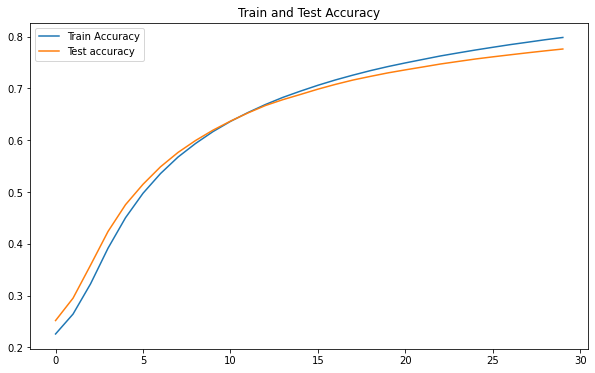

In [28]:
plot_acc(train_acc, test_acc)

After around 200 epochs the model starts to overfit as seen above. We could train the model further with some regularization.

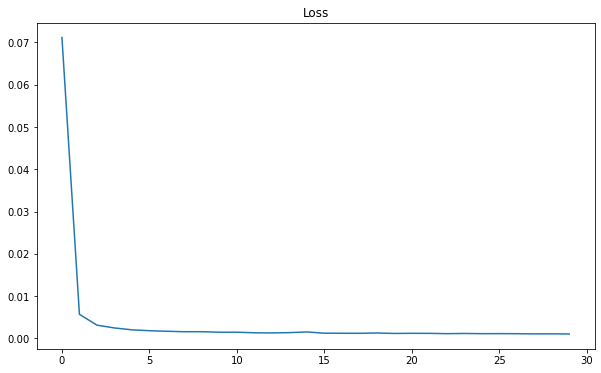

In [29]:
plot_loss(costs)

As can be seen from figures above, train and test accuracy reach approximately 79% at the end of 300 epochs and the average loss reduces to 0.0011